# First simple web-map with Folium


**Date**: 09.06.2024

**Course**: Methods of Spatial Analysis. Advanced Level. // HSE, Moscow, summer 2024


## 1. Import libraries


In [ ]:
## For working with dataframes

import pandas as pd
import geopandas as gpd
import folium
import matplotlib

from shapely import geometry


## 2.Read data from a geojson file


In [254]:
data = gpd.read_file('./okn_points_all.geojson')
data_poi = gpd.read_file('./okn_points.geojson')
data_poly = gpd.read_file('./okn_poly.geojson')
border_poly = gpd.read_file('./city_border.geojson')
zone_poly = gpd.read_file('./protection_zone_single_feature.geojson')
historic_border_poly_1611 = gpd.read_file('./city_border_historic_1611.geojson')
historic_border_poly_1779 = gpd.read_file('./city_border_historic_1779.geojson')
data_poly.head()

,fid,object,adress,category,type,date,Наименование,Статус,Вид объекта,Дата постройки,geometry
0,1,Дом жилой,"Орловская область, г. Орел, ул. Покровская, 27",Регионального значения,Памятник,None,Дом жилой,Регионального значения,Памятник,неизвестно,"MULTIPOLYGON (((303489.497 5872836.094, 303499..."
1,2,Дом жилой,"Орловская область, г. Орел, ул. Ленина, 8",Регионального значения,Памятник,None,Дом жилой,Регионального значения,Памятник,неизвестно,"MULTIPOLYGON (((302906.950 5872469.089, 302904..."
2,3,Дом жилой,"Орловская область, г. Орел, ул. 2-я Курская, 88",Регионального значения,Памятник,None,Дом жилой,Регионального значения,Памятник,неизвестно,"MULTIPOLYGON (((304610.801 5871808.072, 304615..."
3,4,Дом жилой,"Орловская область, г. Орел, ул. Васильевская, 31",Регионального значения,Памятник,None,Дом жилой,Регионального значения,Памятник,неизвестно,"MULTIPOLYGON (((302387.155 5871743.210, 302393..."
4,5,Здание бывшей синагоги,"Орловская область, г. Орел, ул.Советская, д. 16",Регионального значения,Памятник,None,Здание бывшей синагоги,Регионального значения,Памятник,неизвестно,"MULTIPOLYGON (((303640.681 5872887.078, 303624..."


#### \* clear data and save only valuable attributes

(here is an example how to drop fields, you may need to delete more/less depends, you may choose another way to remove attributes )


In [8]:
data = data.drop(columns=['adress' ])

## 2.Create Grid (fishnet)

- to plot concentration of cultural heritage (or any other point layer) with a choropleth map


#### 2.1. Check CRS of current data and decide do you need to reproject it or not?


- here is an example of reading the current crs and reprojecting geodataframe to another crs (you need to choose by yourself do you need it or not), but I'd rather reccommend to use UTM-zone, when you plot data with folium it is better to choose Web Mercator (EPSG:3857)


In [9]:
print(data.crs.name)

#if you need to reproject you can use .to_crs method
#data = data.to_crs("EPSG:4326")


WGS 84


In [10]:
data.crs.name

'WGS 84'

#### 2.2. Get the extent of the data


In [11]:
total_bounds = data.total_bounds
minX, minY, maxX, maxY = total_bounds
total_bounds

array([36.016918  , 52.91775   , 36.104423  , 52.99817535])

#### 2.3. Select cell-size


- what are the units?


In [12]:
square_size = 300

#### 2.4. Create fishnet


- you may choose another way to create using QGIS and read prepared data here


In [13]:
grid_cells = []
x, y = (minX, minY)
geom_array = []

while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size


fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:32637')
fishnet['id'] = fishnet.index

In [14]:
fishnet.head()

,geometry,id
0,"POLYGON ((36.017 52.918, 36.017 352.918, 336.0...",0


- save final grid to file if you need it


In [196]:
fishnet.to_file('grid.gpkg')

## 3. Count Points in Polygon


#### 3.1. Merge fishnet and your points data to count them in polygons


In [ ]:
merged = gpd.sjoin(data, fishnet, how='left', predicate='within')
merged['n'] = 1
dissolve = merged.dissolve(by="index_right", aggfunc="count")
fishnet.loc[dissolve.index, 'n'] = dissolve.n.values


In [198]:
fishnet.explore()

#### 3.2. Plot the result


- we do it just to check the final result, no any other practical need


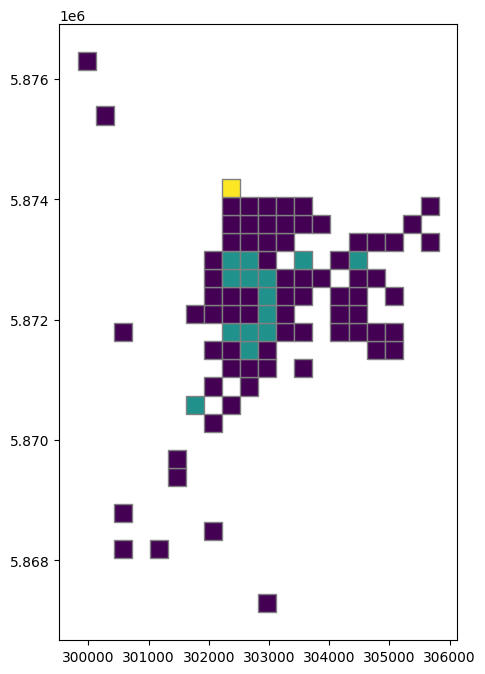

In [199]:
ax = fishnet.plot(column='n', figsize=(12, 8), cmap='viridis', scheme='natural_breaks', k=3, edgecolor="grey")


## 3. Create Web-map


#### 3.1 Map Settings

- carefully look at the function, try to understand what each variable stands for


In [284]:
data = data_poi.to_crs('EPSG:4326')
m = folium.Map(location=[data.centroid.y.mean(), data.centroid.x.mean()], zoom_start=12,  tiles="cartodb positron", control_scale=True)


/var/folders/mr/3qxyb_x542v9qhxq15w35v0c0000gn/T/ipykernel_37456/2602113409.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[data.centroid.y.mean(), data.centroid.x.mean()], zoom_start=12,  tiles="cartodb positron", control_scale=True)


#### 3.2 Additional Settings

In [270]:
folium.GeoJson(
    border_poly,
    name="City border",
    style_function=lambda feature: {
        "fillColor": "darkgrey",
        "fillOpacity": 0,
        "color": "darkgrey",
        "weight": 1,
    },
).add_to(m)

In [271]:
folium.GeoJson(
    zone_poly,
    name="Heritage Protection Zone",
    style_function=lambda feature: {
        "fillColor": "skyblue",
        "fillOpacity": 0.1,
        "color": "skyblue",
        "weight": 1,
        "dashArray": "1, 3"
    },
).add_to(m)

In [272]:
folium.GeoJson(
    historic_border_poly_1611,
    name="1611",
    style_function=lambda feature: {
        "fillColor": "slategray",
        "fillOpacity": 0,
        "color": "slategray",
        "weight": 1.2,
        "dashArray": "4, 4"
    },
    fill=True,
    tooltip="Граница крепости Орел до 1611 года",
).add_to(m)

In [273]:
folium.GeoJson(
    historic_border_poly_1779,
    name="1779",
    style_function=lambda feature: {
        "fillColor": "slategray",
        "fillOpacity": 0,
        "color": "slategray",
        "weight": 1.2,
        "dashArray": "5, 5"
    },
    fill=True,
    tooltip="Граница города согласно плану 1779 года",
).add_to(m)

In [274]:
folium.LayerControl().add_to(m)

#### 3.3 Create a Choropleth map based on a fishnet


In [285]:
folium.Choropleth(
    geo_data=fishnet,
    data=fishnet,
    columns=['id', 'n'],
    fill_color='YlGnBu',
    fill_opacity = 0.5,
    key_on='id',
    nan_fill_opacity=0,
   line_color = "#0000",
   legend_name="Количество объектов культурного наследия",
   name='Heritage Sites Concentration'
).add_to(m)

#### 3.4 Add heritage buildings with tooltips


- try to color heritage buildings based on their conservation status


In [276]:
#colors = ["orange", "yellow", "green", "blue"]
#categories = data_poly['Категория историко-культурного значения'].unique()

folium.GeoJson(
    data_poly,
    name="Heritage buildings",
    tooltip=folium.GeoJsonTooltip(fields=["Наименование"]),
    popup=folium.GeoJsonPopup(fields=["Статус", "Вид объекта", "Дата постройки"]),
    style_function=lambda x: {
        "fillColor": 'yellow'
    },
    highlight_function=lambda x: {"fillOpacity": 0.8},
    zoom_on_click=True,
    show=True,
).add_to(m)


#### 3.5 Add points cluster


In [277]:
from folium.plugins import MarkerCluster

In [278]:
marker_cluster = MarkerCluster(name='Heritage Sites')
mc1= folium.plugins.FeatureGroupSubGroup(marker_cluster, 'Heritage Sites')
m.add_child(marker_cluster)
m.add_child(mc1)
mc1.add_child(folium.GeoJson(data.to_json(), embed=False, show=True))

In [286]:
m

In [280]:
folium.LayerControl().add_to(m)
m

#### 3.6 Add different widgets to map


- import plugins


In [281]:
from folium.plugins import MousePosition
from folium.plugins import Fullscreen

In [282]:
MousePosition().add_to(m)
Fullscreen(
    position="bottomright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(m)


In [283]:
m

## 4. Save map to index.html file and prepare to publish it


In [ ]:
m.save("index.html")